# ML-Engineering-with-Azure-Machine-Learning-Serivce
## Train Model Notebook Local Compute Notebook

The goal of this notebook is to demonstrate leveraging your AML Compute Instance to train a model that uses the Titantic dataset found on the popular Kaggle website.  https://www.kaggle.com/c/titanic-dataset/data
This dataset is in your Data folder.  Azure Machine learning allows you to train models through scripts leveraging popular machine learning frameworks.  In this notebook, we will leverage sklearn to build a logistic model to predict the survial of a person on the Titantic.  

In this notebook we will leverage the Azure ML SDK to create an experiment for tracing metrics to evaluate the training of our model.

# Connect to your workspace

Let's get started by connecting to the AML workspace leveraging the Azure ML SDK 

In [1]:
import azureml.core
from azureml.core import Workspace
import pandas as pd

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.36.0 to work with mlopsdev


# Explore Dataset

You're going to use a Python script to train a machine learning model based on the Titanic datset found in your data folder.  

In [2]:
df= pd.read_csv('./Data/titanic.csv')
print(df.shape)
print(df.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## View Data

In [3]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dataset field information

- **PassengerId**: (remove) Should be removed from model as they are some sort of id.
- **Pclass**: (keep) locates folks on ship *Pclass: 1st = Upper, 2nd = Middle, 3rd = Lower*
- **Name**: (remove) maybe found useful if keeping the surname, but for basic model will remove
- **Sex**: (keep) due to lifeboat priority, will likely be useful
- **Age**: (keep)important due to lifeboat priority
- **SibSp**: (keep) maybe useful, relatives will likely help others
- **Parch**: (keep) maybe useful, relatives will likely help others
- **Ticket**: (remove)
- **Fare**: (remove covered by class)
- **Cabin**: (keep) can be useful in relation of where the cabins are positioned on the ship
- **Embarked**: (keep) unlikely to be useful because all listed embark happened before the disaster

# Data Engineering

## Data Cleansing

We will begin by evaluating the null values in the dataset.  Note that Age, Fare and Cabin contain null values in the dataset.

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

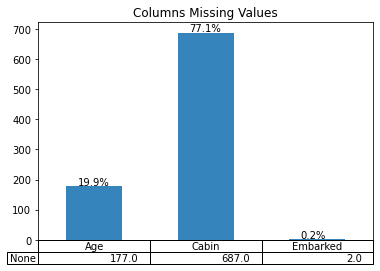

In [5]:
columns_missing = df.isna().sum().where(lambda x : x > 0).dropna()

ax = columns_missing \
.plot(kind='bar', alpha=0.9, title='Columns Missing Values', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

for x in ax.patches:
    ax.text(x.get_x()+.1, x.get_height()+5, \
            str(round((x.get_height()/df.shape[0])*100, 1))+'%')

### Stategy:

- For the Age, we will replace the missing values with the medians of each group
- For cabin we will mark it as X given this is probably an important feature that we would want to include.
- For Embarked,given there are only 2 rows missing this value, we will set these to a value of S

## Cleaning Age Column

Note that Age, a column that has missing data, will likely be impacted by class, as people are more established,their age will likely increase, so to replace these values, we will group by class and sex, calculate a median value and replace the na values in the dataset with the mean

In [6]:
display(df.groupby(['Pclass', 'Sex'])['Age'].count())

display(df.groupby(['Pclass', 'Sex'])['Age'].median())

Pclass  Sex   
1       female     85
        male      101
2       female     74
        male       99
3       female    102
        male      253
Name: Age, dtype: int64

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [7]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Data Engineering

## Feature Engineering

In [8]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [9]:
df['Loc']= df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')

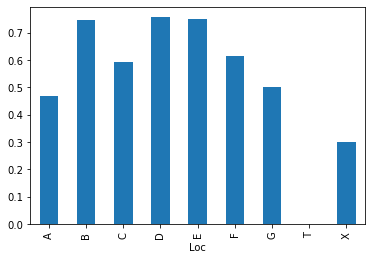

In [10]:
df[['Loc', 'Survived']].groupby('Loc')['Survived'].mean().plot(kind= 'bar')

Now that we have the location on this ship identified,we can drop the 'Cabin' column, and the ticket number

In [11]:
df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [12]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Loc
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,X
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,X
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,X
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,X
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,23.4500,S,X
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,C


In [13]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
Loc            0
dtype: int64

# Feature Engineering
## Create a Group Size

In [14]:
df.loc[:,'GroupSize'] = 1 + df['SibSp'] + df['Parch']

## Fill Missing Embarded with value of S

In [15]:
df['Embarked'] = df['Embarked'].fillna('S')

In [16]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Loc            0
GroupSize      0
dtype: int64

In [17]:
LABEL = 'Survived'
columns_to_drop = ['Name','SibSp', 'Parch', 'Survived']
df_train = df
df = df_train.drop(['Name','SibSp', 'Parch', 'PassengerId'], axis=1)

df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2
2,1,3,female,26.0,7.9250,S,X,1
3,1,1,female,35.0,53.1000,S,C,2
4,0,3,male,35.0,8.0500,S,X,1


In [18]:
import os
script_folder = os.path.join(os.getcwd(), "train")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devbox/code/Users/babal/AMLBook2021/AMLBook2022/Chapter3/train


In [19]:
df.to_csv('./train/dataset.csv')
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2


Starting experiment: titanic_local_compute
AUC: 0.8492261904761904
Accuracy: 0.8097014925373134


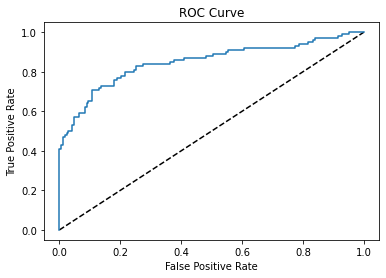

Registering model...
Model trained and registered.


In [20]:
# Separate features and labels
import os
import sys
import argparse
import joblib
import pandas as pd
import numpy as np

from azureml.core import Run, Dataset, Workspace, Experiment

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve

# Calculate model performance metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


def buildpreprocessorpipeline(X_raw):
    categorical_features = X_raw.select_dtypes(include=['object']).columns
    numeric_features = X_raw.select_dtypes(include=['float','int64']).columns

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                                              ('onehotencoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder="drop")
    
    return preprocessor

def model_train(LABEL, df, run):  
    y_raw = df[LABEL]
    X_raw = df.drop([LABEL], axis=1)
    
     # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=0)
    
    lg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)
    
    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lg)])

    model = clf.fit(X_train, y_train)
    
    
    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' + str(auc))
    run.log('AUC', np.float(auc))

    
    # calculate test accuracy
    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)
    print('Accuracy:', acc)
    run.log('Accuracy', np.float(acc))

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    run.log_image(name = "ROC", plot = fig)
    plt.show()

    # plot confusion matrix
    # Generate confusion matrix
    cmatrix = confusion_matrix(y_test, y_hat)
    cmatrix_json = {
        "schema_type": "confusion_matrix",
           "schema_version": "v1",
           "data": {
               "class_labels": ["0", "1"],
               "matrix": [
                   [int(x) for x in cmatrix[0]],
                   [int(x) for x in cmatrix[1]]
               ]
           }
    }
    
    run.log_confusion_matrix('ConfusionMatrix_Test', cmatrix_json)

    return model, auc, acc
    # Save the trained model
    
    
def main():
    # Create an Azure ML experiment in your workspace
    experiment = Experiment(workspace=ws, name= 'titanic_local_compute')
    run = experiment.start_logging()
    print("Starting experiment:", experiment.name)

    df = pd.read_csv('./train/dataset.csv')
 
    model, auc, acc = model_train('Survived', df, run)
    
    os.makedirs('outputs', exist_ok=True)
    # note file saved in the outputs folder is automatically uploaded into experiment record

    model_file = os.path.join('outputs', 'titanic_model.pkl')
    joblib.dump(value=model, filename=model_file)
    
    run.upload_file(name='titanic_model.pkl', path_or_stream=model_file)
    
    # Register the model
    print('Registering model...')
    run.register_model(model_path='titanic_model.pkl', model_name= 'titanic-model',
                   tags={'Model Type':'Logistic Regresssion'},
                   properties={'AUC': np.float(auc), 'Accuracy': np.float(acc)})
    
    run.complete()

    
    print('Model trained and registered.')

if __name__ == "__main__":
    main()